In [19]:
import cv2               #as cv
import urllib
import numpy             as np
import pandas            as pd
import seaborn           as sns
import random
import os
import glob
import shutil
from imutils        import paths
import matplotlib.pyplot as plt
from sklearn.utils  import shuffle
from urllib.request import urlopen
from sklearn.decomposition import PCA
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models              import Sequential
from tensorflow.keras.preprocessing       import image
from tensorflow.keras.utils               import to_categorical
from tensorflow.keras.callbacks           import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers              import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

## 1-) Data Preparation

Data Preprocessing + Data Augmentation

In [20]:
img_folder_path = "Dataset\images"
xml_folder_path = "Dataset\\annotations"

target_size = (416,416)

labels_worker = {"helmet" : 0,
                 "head"   : 1}

labels_worker_reversed = {value:key for key,value in labels_worker.items()}
print(labels_worker)
print(labels_worker_reversed)

{'helmet': 0, 'head': 1}
{0: 'helmet', 1: 'head'}


In [21]:
def load_annotations(xml_folder_path, labels_dict):
    annotations = []
    for xml_file in os.listdir(xml_folder_path):
        if xml_file.endswith('.xml'):
            tree = ET.parse(os.path.join(xml_folder_path, xml_file))
            root = tree.getroot()
            filename = root.find('filename').text
            for obj in root.findall('object'):
                label = obj.find('name').text
                if label in labels_dict:
                    bndbox = obj.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    annotations.append((filename, labels_dict[label], xmin, ymin, xmax, ymax))
    return annotations


In [22]:
def load_dataset(img_folder_path, annotations, target_size):
    images = []
    labels = []
    for ann in annotations:
        img_path = os.path.join(img_folder_path, ann[0])
        if os.path.exists(img_path):
            img = cv.imread(img_path)
            img = cv.resize(img, target_size)
            images.append(img)
            labels.append(ann[1:])
    return np.array(images), np.array(labels)

In [23]:
#load annotations
annotations = load_annotations(xml_folder_path=xml_folder_path,
                               labels_dict    =labels_worker)
#load dataset
images, labels = load_dataset(img_folder_path=img_folder_path,
                              annotations    =annotations,
                              target_size    =target_size)

In [24]:
def split_data(images, labels, train_size=0.7, val_size=0.15, test_size=0.15):
    X_temp, X_test, y_temp, y_test = train_test_split(images,
                                                      labels,
                                                      test_size=test_size,
                                                      random_state=42)
    
    val_size_temp = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, 
                                                      y_temp, 
                                                      test_size=val_size_temp, 
                                                      random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(images,
                                                            labels)

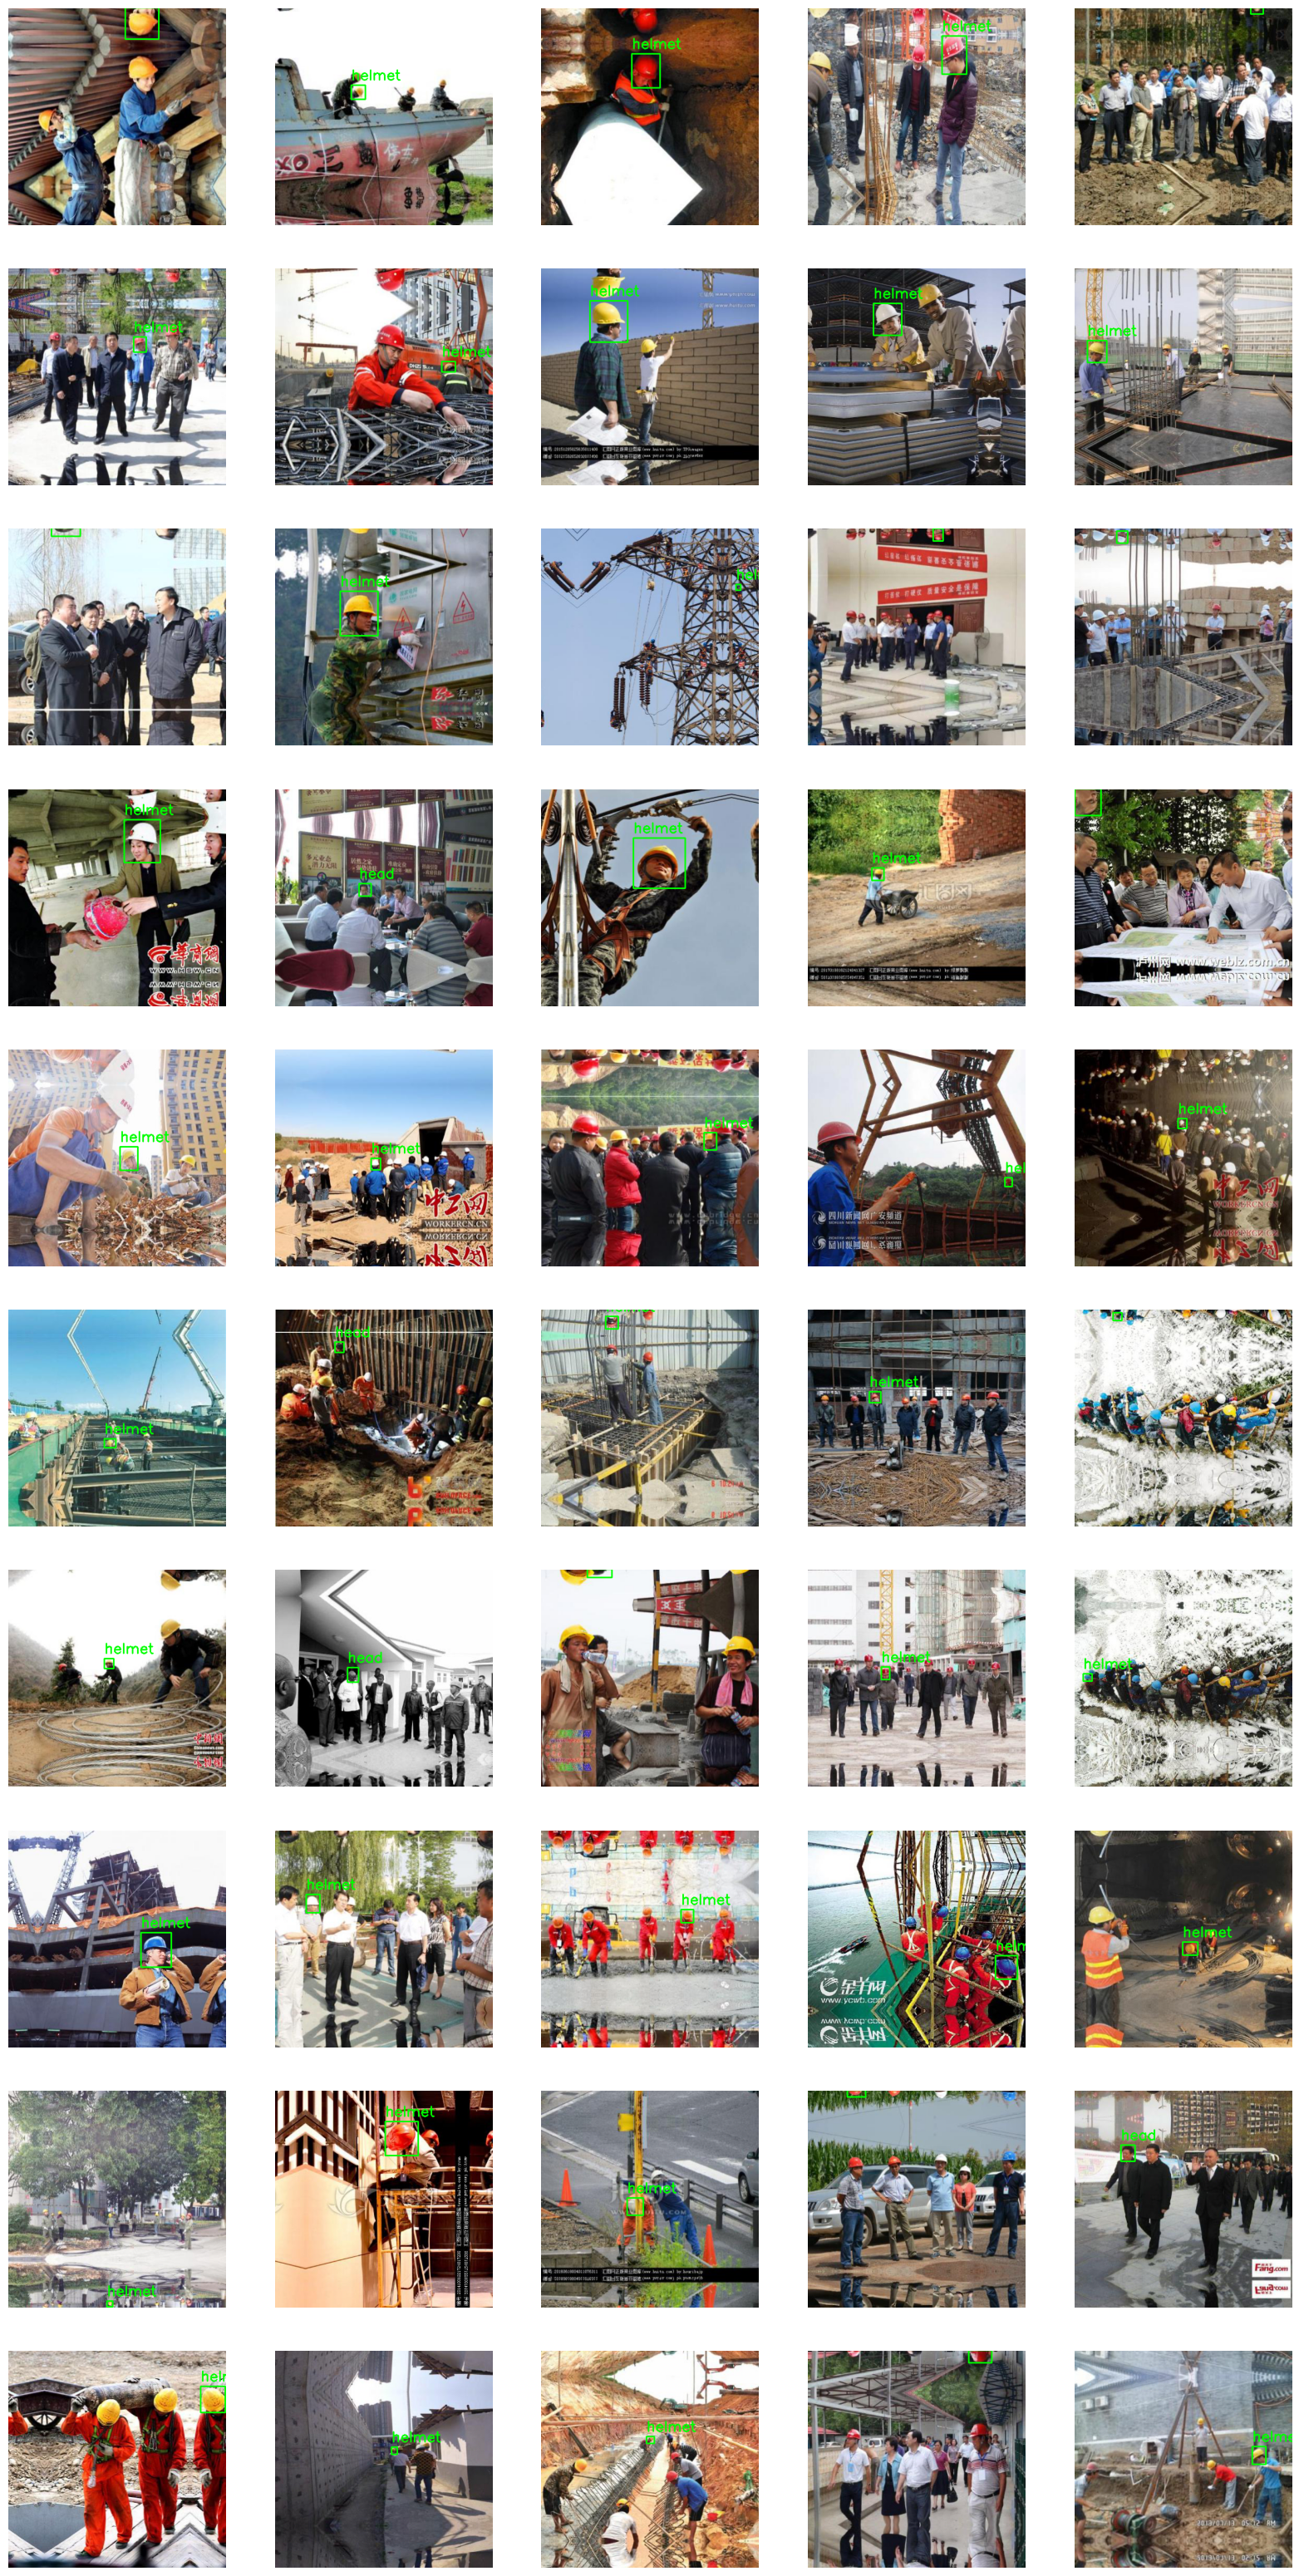

In [32]:
def draw_bbox(image, bboxes, labels_dict):
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, label_idx = bbox
        label = labels_dict.get(label_idx, "unknown")  # Anahtar bulunamazsa "unknown" etiketi kullanılır
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def plot_images_with_bboxes(images, labels, labels_dict, num_images=5):
    rows = (num_images // 5) + int(num_images % 5 != 0)  # Satır sayısını hesapla
    cols = min(num_images, 5)  # Sütun sayısını 5 ile sınırla
    
    plt.figure(figsize=(20, rows * 4))
    for i in range(num_images):
        image = images[i].copy()  # Orijinal görüntüyü bozmadığımızdan emin olalım
        bboxes = []
        label_data = labels[i]  # Her bir görüntü için etiket verileri
        for j in range(0, len(label_data), 5):
            bbox = (label_data[j+1], label_data[j+2], label_data[j+3], label_data[j+4], label_data[j])
            bboxes.append(bbox)
        image_with_bboxes = draw_bbox(image, bboxes, labels_dict)
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Görüntüleri çizdirme
plot_images_with_bboxes(images=X_train, 
                        labels=y_train, 
                        labels_dict=labels_worker_reversed, 
                        num_images=50)

In [26]:
#Data augmentation

#Train set
train_datagen = ImageDataGenerator(rescale            =1.0/255,#Normalization
                                   zoom_range         =0.2,
                                   width_shift_range  =0.2,
                                   height_shift_range =0.2,
                                   rotation_range     =40,
                                   shear_range        =0.2,
                                   horizontal_flip    =True,
                                   vertical_flip      =True,
                                   fill_mode          ="nearest")

#Test and Val set, no augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255) #Normalizaton

In [27]:
#train_generator = train_datagen.flow(X_train,
#                                     y_train,
#                                     batch_size=32,
#                                     shuffle=True,
#                                     seed=42)
#
#val_generator   = test_datagen.flow (X_val,
#                                     y_val,
#                                     batch_size=32,
#                                     shuffle=False,
#                                     seed=42)
#
#test_generator  = test_datagen.flow (X_test,
#                                     y_test,
#                                     batch_size=32,
#                                     shuffle=False,
#                                     seed=42)